# Validation of method

### Table of contents

1. [**Schematic of models**](#schem)
2. [**Synthetic**](#syn)
3. [**Biophysical**](#bio)
4. [**Place cells regression**](#place)
5. [**Place cells comodulation**](#corr)

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr

import optax
jax.config.update('jax_platform_name', 'cpu')
#jax.config.update("jax_enable_x64", True)

import pickle


import sys

sys.path.append("../../../GaussNeuro")
import gaussneuro as lib

sys.path.append("../../scripts/fit")

import template



import matplotlib.pyplot as plt
plt.style.use(['paper.mplstyle'])
#plt.rc('text', usetex=True)

/var/home/dl543/Documents/Learning/nonparametric-modulated-renewal/scripts/plots/../../../GaussNeuro/gaussneuro/likelihoods/renewal.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
jax.config.update('jax_platform_name', 'cpu')
#jax.config.update('jax_disable_jit', True)

double_arrays = False

if double_arrays:
    jax.config.update("jax_enable_x64", True)
    array_type = "float64"
else:
    array_type = "float32"

# seed everything
seed = 123
prng_state = jr.PRNGKey(seed)
rng = np.random.default_rng(seed)

In [3]:
import plot_baselines

jitter = 1e-5
filters_dict = plot_baselines.spike_history_filters(rng, prng_state, jitter, array_type)

In [4]:
a, c = 6., 30.
phi_lower, phi_upper = a * np.log(c) - np.pi, (a * np.log(500 + c) + np.pi) * 0.87
print(phi_lower, phi_upper)

17.26559163638314 35.47760358279412


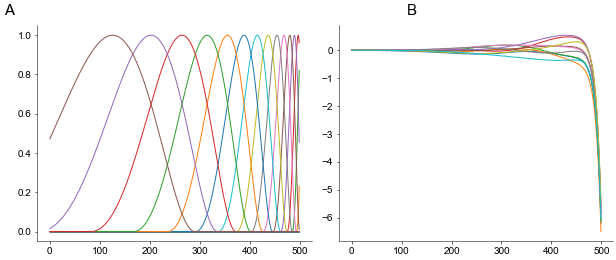

In [5]:
fig = plt.figure(figsize=(8, 3))
fig.text(-0.05, 1.05, 'A', fontsize=15, ha='center')
fig.text(0.65, 1.05, 'B', fontsize=15, ha='center')



widths = [1, 1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.0, 
                        left=0.0, right=1., wspace=0.1)

ax = fig.add_subplot(spec[0, 0])

filter_t = filters_dict["glm_filter"]
t = np.arange(filter_t.shape[0])
ax.plot(t, filter_t[:, :, 0])


ax = fig.add_subplot(spec[0, 1])

filter_t = filters_dict["gp_filter"]
t = np.arange(filter_t.shape[1])

tr = 2
ax.plot(t, filter_t[:, :, 1, 0].T)



plt.show()

### Schematic of model

In [3]:
import plot_schematic

In [8]:
evalsteps = 10000
L = 100.

evals, spiketimes, pos_sample, ISIs, tISI, tuISIs, tau, tau_tilde = plot_schematic.model_inputs(
    prng_state, evalsteps, L)


num_samps = 10
evalsteps = 500
L = 3.0

cisi_t_eval, ISI_densities, cisi_tau_tilde, log_rho_tildes = plot_schematic.BNPP_samples(
    prng_state, rng, num_samps, evalsteps, L)

In [ ]:
B
# a.u. tau, s for t, show the absolute numbers on time
# label for histogram
C
# log lambda -> log rho

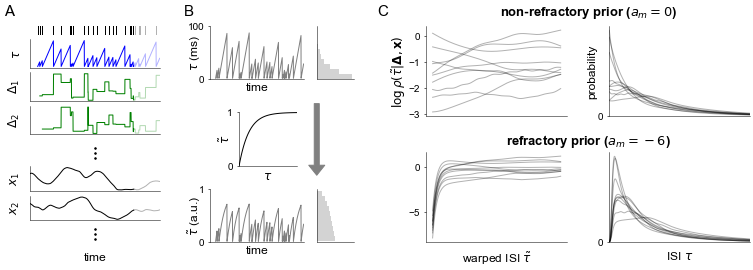

In [21]:
fig = plt.figure(figsize=(10, 3))
fig.text(-0.03, 1.05, 'A', fontsize=15, ha='center')
fig.text(0.22, 1.05, 'B', fontsize=15, ha='center')
fig.text(0.49, 1.05, 'C', fontsize=15, ha='center')



T = 800
Te = 1000


widths = [1]
heights = [0.3, 1, 1, 1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.5, 
                        left=0.0, right=0.18, wspace=0.1)


ax = fig.add_subplot(spec[0, 0])
spkts = spiketimes[spiketimes < T]
for st in spkts:
    ax.plot(evals[st]*np.ones(2), np.linspace(0, 1, 2), c='k')
    spkts = spiketimes[(T <= spiketimes) & (spiketimes < Te)]
for st in spkts:
    ax.plot(evals[st]*np.ones(2), np.linspace(0, 1, 2), c='k', alpha=0.3)
ax.set_xlim([evals[0], evals[Te]])
ax.set_ylim([0, 1])
ax.axis('off')


ax = fig.add_subplot(spec[1, 0])

ax.plot(evals[:T], ISIs[:T, 0, 0], c='b')
ax.plot(evals[T:Te], ISIs[T:Te, 0, 0], c='b', alpha=0.3)
ax.set_xlim([evals[0], evals[Te]])
ax.set_ylabel(r'$\tau$')
ax.set_yticks([])
ax.set_xticks([])


for k in range(2):
    ax = fig.add_subplot(spec[k + 2, 0])
    ax.plot(evals[:T], ISIs[:T, 0, k+1], c='g')
    ax.plot(evals[T:Te], ISIs[T:Te, 0, k+1], c='g', alpha=0.3)
    ax.set_xlim([evals[0], evals[Te]])
    ax.set_xticks([])
    ax.set_ylim(0)
    ax.set_yticks([])
    ax.set_ylabel('$\Delta_{}$'.format(k+1))

    
widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.475, bottom=0.375, 
                        left=0.0, right=0.18, wspace=0.0)
ax = fig.add_subplot(spec[0, 0])
ax.scatter(np.zeros(3), np.arange(3), c='k', marker='.')
ax.set_ylim([-0.5, 3.5])
ax.axis('off')
    

widths = [1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.35, bottom=0.1, 
                        left=0.0, right=0.18, wspace=0.0)

for d in range(2):
    ax = fig.add_subplot(spec[d, 0])
    ax.plot(evals[:T], pos_sample[0, :T, d, 0], c='k')
    ax.plot(evals[T:Te], pos_sample[0, T:Te, d, 0], alpha=0.3, c='k')
    ax.set_xlim([evals[0], evals[Te]])
    ax.set_ylabel('$x_{}$'.format(d+1))
    ax.set_xticks([])
    ax.set_yticks([])
    
ax.set_xlabel('time', labelpad=32)


widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.1, bottom=0.0, 
                        left=0.0, right=0.18, wspace=0.0)
ax = fig.add_subplot(spec[0, 0])
ax.scatter(np.zeros(3), np.arange(3), c='k', marker='.')
ax.set_ylim([-0.5, 3.5])
ax.axis('off')



### time warping ###
widths = [1, 0.4]
heights = [1, 1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.0, 
                        left=0.25, right=0.45, hspace=2.1)

ax = fig.add_subplot(spec[0, 0])
ax.plot(evals[:Te], ISIs[:Te, 0, 0] * 1e3, c='gray')
ax.set_xticks([])
ax.set_xlim([evals[0], evals[Te]])
ax.set_xlabel('time', labelpad=4)
ax.set_ylabel(r'$\tau$ (ms)', labelpad=-14)
ax.set_ylim([0, 100])
ax.set_yticks([0, 100])

ax = fig.add_subplot(spec[0, 1])
ax.hist(ISIs[:, 0, 0], orientation='horizontal', color='lightgray', density=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(0)


ax = fig.add_subplot(spec[1, 0])
ax.plot(evals[:Te], tISI[:Te, 0], c='gray')
ax.set_xticks([])
ax.set_xlim([evals[0], evals[Te]])
ax.set_xlabel('time', labelpad=4)
ax.set_ylabel(r'$\tilde{\tau}$ (a.u.)', labelpad=-4)
ax.set_ylim([0, 1])
ax.set_yticks([0, 1])

ax = fig.add_subplot(spec[1, 1])
ax.hist(tISI[:, 0], orientation='horizontal', color='lightgray', density=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim([0, 1])
ax.set_xlim([0, 3])


widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.6, bottom=0.35, 
                        left=0.29, right=0.37)

ax = fig.add_subplot(spec[0, 0])
ax.plot(tau[:, 0], tau_tilde[:, 0], c='k')
ax.set_xticks([])
ax.set_yticks([0, 1])
ax.set_xlim([tau[0, 0], tau[-1, 0]])
ax.set_ylim([0, 1])
ax.set_xlabel(r'$\tau$', labelpad=4)
ax.set_ylabel(r'$\tilde{\tau}$', labelpad=-5)

ax.annotate("", xy=(1.35, -0.2), xytext=(1.35, 1.2), rotation=np.pi/2., xycoords='axes fraction', 
    arrowprops=dict(arrowstyle="simple, head_width=1.6, head_length=1.0, tail_width=0.5", color='gray'), 
    annotation_clip=False)


### log intensity and ISI ###
n = 0
f_dim = 0

widths = [1, 1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.0, 
                        left=0.55, right=1.0, hspace=0.4, wspace=0.3)

fig.text(0.775, 1.05, r'non-refractory prior ($a_m = 0$)', fontsize=13, 
         fontweight='bold', ha='center')
fig.text(0.775, 0.45, r'refractory prior ($a_m = -6$)', fontsize=13, 
         fontweight='bold', ha='center')

ax = fig.add_subplot(spec[0, 0])
ax.plot(cisi_tau_tilde, log_rho_tildes[0][:, f_dim, :].T, c='k', alpha=0.3)
ax.set_xticks([])
#ax.set_yticks([])
ax.set_ylabel(r'$\log \rho(\tilde{\tau}|\mathbf{\Delta}, \mathbf{x})$', labelpad=1)

ax = fig.add_subplot(spec[1, 0])
ax.plot(cisi_tau_tilde, log_rho_tildes[1][:, f_dim, :].T, c='k', alpha=0.3)
ax.set_xticks([])
#ax.set_yticks([])
ax.set_xlabel(r'warped ISI $\tilde{\tau}$')

ax = fig.add_subplot(spec[0, 1])
ax.plot(cisi_t_eval, ISI_densities[0][:, f_dim, :].T, c='k', alpha=0.3)
ax.set_xticks([])
ax.set_yticks([0])
ax.set_ylabel('probability', labelpad=1)
ax.set_xlim([cisi_t_eval[0], cisi_t_eval[-1]])
ax.set_ylim(0)

ax = fig.add_subplot(spec[1, 1])
ax.plot(cisi_t_eval, ISI_densities[1][:, f_dim, :].T, c='k', alpha=0.3)
ax.set_xticks([])
ax.set_yticks([0])
ax.set_xlabel(r'ISI $\tau$')
ax.set_xlim([cisi_t_eval[0], cisi_t_eval[-1]])
ax.set_ylim(0)



#plt.savefig('../saves/schematic.pdf')
plt.show()

In [5]:
ts = 3000
dt = 0.001
p = 0.003
spikes_at = rng.binomial(1, p, size=(ts,))
spike_times = np.where(spikes_at > 0)[0]

time_t = np.arange(ts) * dt
rates_t = 30. * (np.sin(time_t * (1 + np.exp( -1.5 * (time_t - time_t[-1]/2.) ** 2 )))**2 + \
    np.exp( -0.5 * (time_t - time_t[-1]/3.) ** 2 ))


rtime_t = np.cumsum(rates_t * dt)
rspike_times = np.ceil(rtime_t[spike_times] / dt).astype(int)

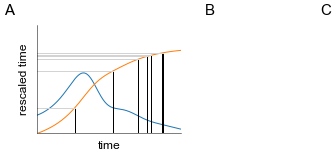

In [6]:
fig = plt.figure(figsize=(8, 3))
fig.set_facecolor('white')

fig.text(-0.05, 1.05, 'A', fontsize=15, ha='center')
fig.text(0.3, 1.05, 'B', fontsize=15, ha='center')
fig.text(0.5, 1.05, 'C', fontsize=15, ha='center')


### rate rescaling ###
widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.5, 
                        left=0.0, right=0.25, wspace=0.1)

ax = fig.add_subplot(spec[0, 0])

ax.plot(time_t, rates_t)
ax.plot(time_t, rtime_t)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('time')
ax.set_ylabel('rescaled time')

ax.set_xlim([time_t[0], time_t[-1]])
ax.set_ylim([rtime_t[0], 1.3*rtime_t[-1]])
for st, rst in zip(spike_times, rspike_times):
    ax.plot(np.ones(2)*st*dt, [0., rtime_t[st]], c='k')
    ax.plot([0., time_t[st]], np.ones(2)*rst*dt, c='lightgray')

In [ ]:
# each cell has unique colour
# no rate rescaling
A
# ground truth cells, bottom : renewal densities
B 
# fitted rate maps from models
# maybe plot: Poisson rates too
# posterior samples
C
# qq plots

In [3]:
datadir = '../saves/'
name = 'synthetic_results'

results = pickle.load(
    open(datadir + name + ".p", "rb")
)

In [4]:
results["tuning"]['warp_tau']

array([0.8467633, 1.7683899, 1.2289314, 1.4755108, 1.0157384, 0.9616031,
       0.9569549, 1.2512869, 1.1838311], dtype=float32)

NameError: name 'reg_config_names' is not defined

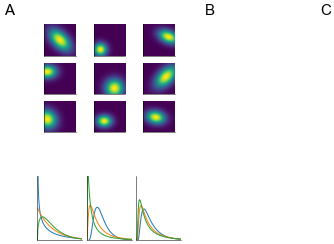

In [9]:
fig = plt.figure(figsize=(8, 3))
fig.set_facecolor('white')

fig.text(-0.05, 1.05, 'A', fontsize=15, ha='center')
fig.text(0.3, 1.05, 'B', fontsize=15, ha='center')
fig.text(0.5, 1.05, 'C', fontsize=15, ha='center')


### rate rescaling ###
widths = [1] * 3
heights = [1] * 3
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.5, 
                        left=0.0, right=0.25, wspace=0.1)

for n in range(3):
    for m in range(3):
        k = 3*n + m
        ax = fig.add_subplot(spec[n, m])

        ax.imshow(rates[..., k], extent=[xlist[0][0], xlist[0][-1], xlist[1][0], xlist[1][-1]], 
                  origin='lower', cmap='viridis')
        ax.set_xlim([xlist[0][0], xlist[0][-1]])
        ax.set_ylim([xlist[1][0], xlist[1][-1]])
        ax.set_xticks([])
        ax.set_yticks([])


widths = [1, 1, 1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.3, bottom=0.0, 
                        left=0.0, right=0.25, wspace=0.1)

ISI = jnp.linspace(1e-12, 3., 100)[:, None]

for en, rtype in enumerate(['gamma', 'lognorm', 'invgauss']):
    rm, _ = generate.get_renewal(rtype, 3, dt)
    ll = jax.vmap(rm.log_density)(ISI)
    
    ax = fig.add_subplot(spec[0, en])
    ax.plot(ISI, np.exp(ll)[:, :])
    ax.set_xlim([0, ISI[-1]])
    ax.set_ylim([0, 2.])
    ax.set_xticks([])
    ax.set_yticks([])
    
    
### KS statistics ###
widths = [1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.0, 
                        left=0.3, right=0.4, wspace=0.1)

for en, n in enumerate(reg_config_names):
    ax = fig.add_subplot(spec[en, 0])

    dd = regression_dict[n]
    sort_cdfs = dd['KS_quantiles']

    for n in range(len(sort_cdfs)):
        if sort_cdfs[n] is not None:
            ax.plot(np.linspace(0., 1., len(sort_cdfs[n])), sort_cdfs[n], alpha=0.7)
    ax.plot(np.linspace(0., 1., 100), np.linspace(0., 1., 100), c='k')


### tuning curves ###

        

ax.annotate("", xy=(1.35, -0.2), xytext=(1.35, 1.2), rotation=np.pi/2., xycoords='axes fraction', 
    arrowprops=dict(arrowstyle="simple, head_width=1.6, head_length=1.0, tail_width=0.5", color='gray'), 
    annotation_clip=False)

ax.annotate("", xy=(1.35, -0.2), xytext=(1.35, 1.2), rotation=np.pi/2., xycoords='axes fraction', 
    arrowprops=dict(arrowstyle="simple, head_width=1.6, head_length=1.0, tail_width=0.5", color='gray'), 
    annotation_clip=False)

ax.annotate("", xy=(1.35, -0.2), xytext=(1.35, 1.2), rotation=np.pi/2., xycoords='axes fraction', 
    arrowprops=dict(arrowstyle="simple, head_width=1.6, head_length=1.0, tail_width=0.5", color='gray'), 
    annotation_clip=False)


### conditional ISI distributions ###
widths = [1, 1, 1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.4, bottom=0.0, 
                        left=0.5, right=1.0, wspace=0.1)   
    
t_eval = tuning_dict['ISI_t_eval']
ne = 5
loc_inds = [0, 3, 5]
for en, loc_ind in enumerate(loc_inds):
    ax = fig.add_subplot(spec[0, en])
    dens = tuning_dict['ISI_densities'][loc_ind, :, ne, :]
    ax.plot(t_eval, dens.T, c='k', alpha=0.2)
    
    if en == 0:
        ax.set_ylabel('probability')
    elif en == 1:
        ax.set_ylabel('ISI (s)')
        
        
        
    
### kernel lengthscales ###
widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.5, 
                        left=0.85, right=1.0, wspace=0.1)

ls = tuning_dict['len_deltas']
tls = tuning_dict['len_tau']
cs = [
    'b',
    'g',
    'r',
    'c',
    'm',
    'y',
    'k',
    'orange',
    'cyan'
]

ax = fig.add_subplot(spec[0, 0])
for n in range(9):
    lens = ls[n]
    tlen = tls[n]
    ax.scatter(n*np.ones_like(lens), lens, marker='.', c=cs[n])
    ax.scatter(n*np.ones(1), tlen, marker='x', c=cs[n], s=20)
    ax.set_yscale('log')
    ax.set_ylabel('kernel timescales')
    ax.plot([-.5, 9.5], 3. * np.ones(2), '--', color='gray')
    ax.set_xlim([-.5, 9.5])
    
        
        
        
#plt.savefig('../saves/synthetic.pdf')
plt.show()

## th1

In [ ]:
datadir = '../saves/'
name = 'synthetic_results'

results = pickle.load(
    open(datadir + name + ".p", "rb")
)

In [ ]:
reg_config_names = list(regression_dict.keys())

regression_dict = results["regression"]

In [ ]:
fig = plt.figure(figsize=(8, 4))

#fig.text(0.22, 1.05, 'repeatable trials', fontsize=12, ha='center')
#fig.text(0.78, 1.05, 'naturalistic behaviour', fontsize=12, ha='center')


### likelihoods ###
widths = [1]
heights = [1, 1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.6, 
                        left=0.0, right=0.1, wspace=0.1)

mdls = len(reg_config_names)
test_lls = np.array([regression_dict[n]['test_ells'] for n in reg_config_names])
train_lls = np.array([regression_dict[n]['train_ell'] for n in reg_config_names])

ax = fig.add_subplot(spec[0, 0])
means = test_lls.mean(-1)
sems = test_lls.std(-1) / np.sqrt(test_lls.shape[-1])
ax.bar(np.arange(mdls), means, yerr=sems, 
       align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylim(7.5 * 1e4)

# ax = fig.add_subplot(spec[1, 0])
# means = train_lls
# ax.bar(np.arange(mdls), means, 
#        align='center', alpha=0.5, ecolor='black', capsize=10)
# ax.set_ylim(3.5 * 1e5)



widths = [1, 1, 1, 1, 1, 1]
heights = [1, 0.1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.6, 
                        left=0.15, right=1., hspace=0.3, wspace=0.1)

test_fold = 0
ne = 0
for en, n in enumerate(reg_config_names):
    pred_lint = regression_dict[n]['pred_log_intensities']
    pred_ts = regression_dict[n]['pred_ts']
    ax = fig.add_subplot(spec[0, en])
    ax.plot(pred_ts, pred_lint[test_fold][0, ne, :])
    #sts = regression_dict[n]['pred_spiketimes'][test_fold][ne]
    #ax = fig.add_subplot(spec[1, en])
    #for st in sts:
    #    ax.plot(st*np.ones(2), np.linspace(0, 1, 2))


### KS statistics ###
widths = [1, 1, 1, 1, 1, 1, 1]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.4, bottom=0.0, 
                        left=0.0, right=1., wspace=0.1)

ax = fig.add_subplot(spec[0, 0])

mdls = len(reg_config_names[:1])
p_vals = [regression_dict[n]['KS_p_value'] for n in reg_config_names]
#p_vals = [[0 if v is None else v for v in d] for d in p_vals]

ax.violinplot(
    p_vals, list(range(mdls)), points=20, widths=0.3,
    showmeans=True, showextrema=True, showmedians=True, 
    bw_method=1e-2, #'silverman', 
)

for en, n in enumerate(reg_config_names):
    quantiles = regression_dict[n]['KS_quantiles']

    ax = fig.add_subplot(spec[0, en + 1])
    for n in range(len(quantiles)):
        if quantiles[n] is not None:
            ax.plot(np.linspace(0., 1., len(quantiles[n])), quantiles[n], alpha=0.7)
    ax.plot(np.linspace(0., 1., 100), np.linspace(0., 1., 100), c='k')






plt.show()

## hc3

In [11]:
datadir = '../saves/'
name = 'hc3_results'

results = pickle.load(
    open(datadir + name + ".p", "rb")
)

In [18]:
reg_config_names = list(regression_dict.keys())

regression_dict = results["regression"]

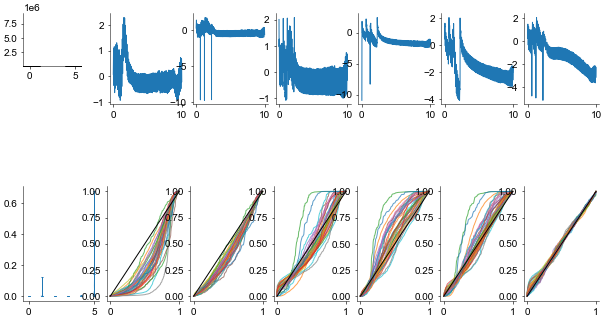

In [25]:
fig = plt.figure(figsize=(8, 4))

#fig.text(0.22, 1.05, 'repeatable trials', fontsize=12, ha='center')
#fig.text(0.78, 1.05, 'naturalistic behaviour', fontsize=12, ha='center')


### likelihoods ###
widths = [1]
heights = [1, 1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.6, 
                        left=0.0, right=0.1, wspace=0.1)

mdls = len(reg_config_names)
test_lls = np.array([regression_dict[n]['test_ells'] for n in reg_config_names])
train_lls = np.array([regression_dict[n]['train_ell'] for n in reg_config_names])

ax = fig.add_subplot(spec[0, 0])
means = test_lls.mean(-1)
sems = test_lls.std(-1) / np.sqrt(test_lls.shape[-1])
ax.bar(np.arange(mdls), means, yerr=sems, 
       align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylim(7.5 * 1e4)

# ax = fig.add_subplot(spec[1, 0])
# means = train_lls
# ax.bar(np.arange(mdls), means, 
#        align='center', alpha=0.5, ecolor='black', capsize=10)
# ax.set_ylim(3.5 * 1e5)



widths = [1, 1, 1, 1, 1, 1]
heights = [1, 0.1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.6, 
                        left=0.15, right=1., hspace=0.3, wspace=0.1)

test_fold = 0
ne = 0
for en, n in enumerate(reg_config_names):
    pred_lint = regression_dict[n]['pred_log_intensities']
    pred_ts = regression_dict[n]['pred_ts']
    ax = fig.add_subplot(spec[0, en])
    ax.plot(pred_ts, pred_lint[test_fold][0, ne, :])
    #sts = regression_dict[n]['pred_spiketimes'][test_fold][ne]
    #ax = fig.add_subplot(spec[1, en])
    #for st in sts:
    #    ax.plot(st*np.ones(2), np.linspace(0, 1, 2))


### KS statistics ###
widths = [1, 1, 1, 1, 1, 1, 1]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.4, bottom=0.0, 
                        left=0.0, right=1., wspace=0.1)

ax = fig.add_subplot(spec[0, 0])

mdls = len(reg_config_names)
p_vals = [regression_dict[n]['KS_p_value'] for n in reg_config_names]
#p_vals = [[0 if v is None else v for v in d] for d in p_vals]

ax.violinplot(
    p_vals, list(range(mdls)), points=20, widths=0.3,
    showmeans=True, showextrema=True, showmedians=True, 
    bw_method=1e-2, #'silverman', 
)

for en, n in enumerate(reg_config_names):
    quantiles = regression_dict[n]['KS_quantiles']

    ax = fig.add_subplot(spec[0, en + 1])
    for n in range(len(quantiles)):
        if quantiles[n] is not None:
            ax.plot(np.linspace(0., 1., len(quantiles[n])), quantiles[n], alpha=0.7)
    ax.plot(np.linspace(0., 1., 100), np.linspace(0., 1., 100), c='k')






plt.show()

In [83]:
def get_renewal(renewal_type, neurons, dt):
    if renewal_type == 'gamma':
        alpha = np.linspace(0.2, 100.5, neurons)
        renewal = lib.likelihoods.GammaRenewal(
            neurons,
            dt,
            alpha,
        )

    elif renewal_type == 'lognorm':
        sigma = np.linspace(0.5, 1.5, neurons)
        renewal = lib.likelihoods.LogNormalRenewal(
            neurons,
            dt,
            sigma,
        )

    elif renewal_type == 'invgauss':
        mu = np.linspace(1.0, 1.5, neurons)
        renewal = lib.likelihoods.InverseGaussianRenewal(
            neurons,
            dt,
            mu,
        )
        
    elif renewal_type == 'exponential':
        renewal = lib.likelihoods.ExponentialRenewal(
            neurons,
            dt,
        )
    
    return renewal

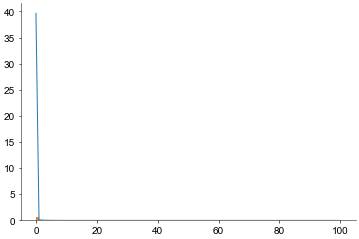

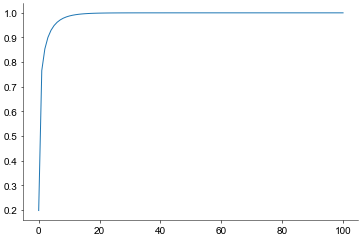

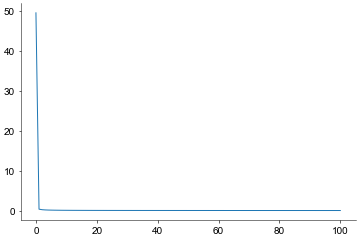

In [84]:
dt = 0.001
rm = get_renewal('gamma', 1, dt)

mc = 1000
samples = jax.vmap(rm.sample_ISI)(jr.split(prng_state, mc))


ISI = jnp.linspace(0.001, 100., 100)[:, None]

ll = jax.vmap(rm.log_density)(ISI)
plt.plot(ISI, np.exp(ll)[:, :])
plt.hist(np.array(samples)[:, -1], bins=np.array(ISI)[:, 0], density=True)
plt.show()

cd = jax.vmap(rm.cum_density)(ISI)
plt.plot(ISI, cd[:, :])
plt.show()

lh = jax.vmap(rm.log_hazard)(ISI)
plt.plot(ISI, jnp.exp(lh[:, :]))
plt.show()

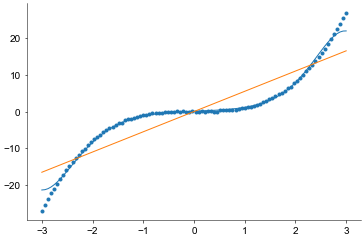

In [69]:
n = 0

plt.plot(X[n, :], post_mean[n, :])
plt.plot(X[n, :], a[n] * X[n, :] + b[n])
plt.scatter(X[n], Y[n])
plt.show()

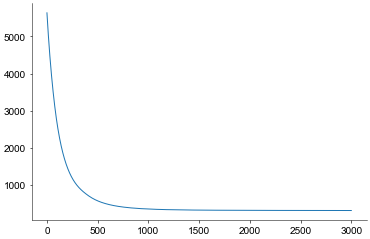

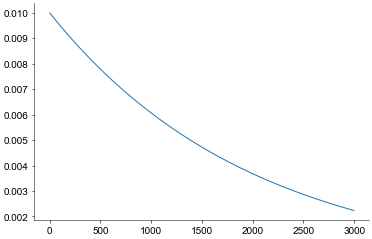

In [71]:
plt.plot(tracker['train_loss_epochs'])
plt.show()

plt.plot(tracker['learning_rates'])
plt.show()

NameError: name 'an_pos' is not defined

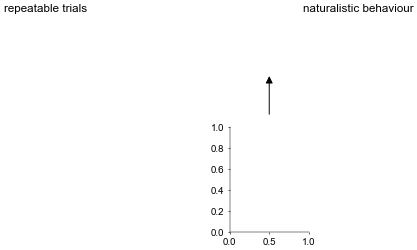

In [85]:
fig = plt.figure(figsize=(8, 3))

fig.text(0.22, 1.05, 'repeatable trials', fontsize=12, ha='center')
fig.text(0.78, 1.05, 'naturalistic behaviour', fontsize=12, ha='center')


    
### behaviour ###


# position
tps = [300, 1000, 1700]
widths = [1, 1, 1]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, hspace=0.0, 
                        height_ratios=heights, top=0.5, bottom=0.0, 
                        left=0.55, right=1., wspace=0.1)

for k in range(3):
    ax = fig.add_subplot(spec[0, k])
    
    ax.annotate("", xy=(0.5, 1.5), xytext=(0.5, 1.1), rotation=np.pi/2., xycoords='axes fraction', 
                arrowprops=dict(arrowstyle="-|>, head_width=.3, head_length=.6", color='k'), 
                annotation_clip=False)
    
    tp = tps[k]

    x = an_pos[0, 0, tp]
    y = an_pos[0, 1, tp]
    dx = (an_pos[0, 0, tp+1]-an_pos[0, 0, tp])*100
    dy = (an_pos[0, 1, tp+1]-an_pos[0, 1, tp])*100

    ax.scatter(x, y, marker='o', facecolor='k', s=40)
    #ax.arrow(x, y, dx, dy)
    ax.plot(an_pos[0, 0, :tp], an_pos[0, 1, :tp], c='k')
    ax.plot(an_pos[0, 0, tp:], an_pos[0, 1, tp:], c='lightgray')
    ylims = ax.get_ylim()
    ax.set_ylim(-2.4, 2.4)
    ax.set_xlim(-2.4, 2.4)
    ax.set_aspect(1.)
    utils.plot.decorate_ax(ax)
            
            
plt.savefig('output/comparison.pdf')
plt.show()

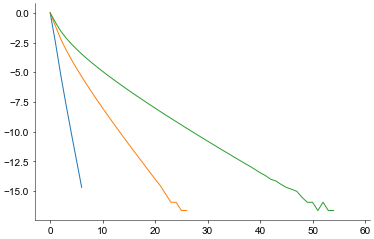

In [77]:
from tensorflow_probability.substrates import jax as tfp

igd = tfp.distributions.InverseGaussian(jnp.linspace(0.5, 1.5, 3), jnp.ones(3))

t = jnp.linspace(0.001, 100., 100)[:, None]
lh = igd.log_survival_function(t)

plt.plot((lh[:, :]))
plt.show()